# Understanding and Measuring eBook Packages: Purchasing Patterns, Usage, and an Analysis Framework
## 2018 Charleston Conference
#### John Vickery 
#### This notebook covers the "Analysis Framework" portion of the presentation

## About me...

I am Analytics Coordinator and Collections & Research Librarian for Social Sciences at NC State Libraries.  
My work primarily involves data analysis for internal, operational decision making.  
I do most of my work in Python, SAS and R.

You can find this notebook and sample data to run it on GitHub  
https://github.com/jnvickery/EbookPackageAnalysis

## Analysis framework for ebook packages

We'll use Elsevier packages purchased by NC State between 2012 and 2016 as an example.  
The aim is to analyze usage at the package level to inform future decisions to update the collection. 

## What you need for the framework:
1. List of packages purchased with date (or year) purchased
2. Publisher title lists for each package
3. Yearly COUNTER usage reports

## About the data files:

### List of packages purchased by year
- This is a homegrown file that will vary depending on your situation
- It will require a link to the package title lists. In this case it's Elsevier's "Package Code"
- *The important part is to determine the first year that usage would be relevant based on the purchase year*

### Title lists
- These are the lists of titles in Elsevier ebook packages
- Downloaded from: https://www.elsevier.com/solutions/sciencedirect/content/book-title-lists
- Each title list file has the following columns (Thanks Elsevier!). We'll just use the ones in **bold**
    1. Source
    2. **Package name**
    3. **Package ID**
    4. **ISBN**
    5. **Unformatted ISBN**
    6. **Book Title**
    7. **Year**
    8. ISSN
    9. Series Title
    10. Volume
    11. Imprint
    12. Available Online
    13. Status
    14. Remarks
    15. Shortcut URL

### COUNTER reports by year
- These are the regular BR2 reports

- These are saved to the same folder and named "YYYY_Elsevier.xlsx" (e.g. 2016_Elsevier.xlsx) 

## So... down in the weeds a bit with some python code

### The first thing we need to do is import some python packages

In [1]:
# import the python packages that we need
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Next, use the "read_excel" method to create a dataframe of package codes that have been purchased
1. This file inlcudes the Elsevier "Package Code" identifying each collection
2. Date purchased
3. The first year that usage would be relevant
    - For example, if the "Agricultural and Biological Sciences pre-2007" collection was purchased at the end of 2011 then usage from 2012 would be the first relevant usage

In [2]:
# get list of elsevier ebook package codes into a dataframe
pkgcodes = pd.read_excel('H:\presentations and conferences\Charleston\Charleston 2018\presentation\packageNames.xlsx',
                         usecols='C,E',
                         converters={'PackageCode':str,'FirstUsageDate':int})

# and look at the first few rows
pkgcodes.head()

,PackageCode,FirstUsageDate
0,EBCABS,2012
1,EBCABS06,2012
2,EBCABS95S,2012
3,EBCABS14,2014
4,EBCABS15,2015


### The next few cells get the ebook title lists from whatever folder you saved them to

In [3]:
# build out base directory for files
# change to match your folder structure
mydir = os.path.join('H:\presentations and conferences',
                     'Charleston',
                     'Charleston 2018',
                     'presentation',
                     'title lists')

In [4]:
# initialize a dataframe for the title lists
titles = pd.DataFrame()

#### Since there are several title list files, use a "for loop" to read each one and save them to the "titles" dataframe

In [5]:
# loop through the Elsevier title lists
# we're also replacing spaces in the column names with an underscore
for yr in range(2007,2018):
    fpath = os.path.join(mydir,'ebook'+str(yr)+'.xlsx')
    df = pd.read_excel(fpath, converters={'ISBN':str})
    df.columns = [c.replace(' ', '_') for c in df.columns]
    titles = titles.append(df)

** Check out the columns from the title lists that were imported **

In [6]:
# check out the dataframe
titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9071 entries, 0 to 1238
Data columns (total 16 columns):
Available_Online       9071 non-null object
Book_Title             9071 non-null object
Editor(s)/Author(s)    1972 non-null object
ISBN                   9054 non-null object
ISSN                   665 non-null object
Imprint                9054 non-null object
Package_ID             9063 non-null object
Package_name           9071 non-null object
Remarks                43 non-null object
Series_Title           1997 non-null object
Shortcut_URL           9054 non-null object
Source                 9071 non-null object
Status                 80 non-null object
Unformatted_ISBN       7099 non-null float64
Volume                 588 non-null object
Year                   9071 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 1.2+ MB


#### Now we need to do a little clean-up of the title lists  
1. keep selected columns
2. subset them to only include purchased packages
3. reformat ISBN to remove dashes

In [7]:
# just keep the columns we want
titles = titles[['Book_Title', 'ISBN', 'Package_ID', 'Package_name', 'Year']]

In [8]:
# subset title lists where code only in list of purchased codes
titles = titles[titles['Package_ID'].isin(pkgcodes['PackageCode'])]

In [9]:
# reformat ISBN to remove dashes
titles['ISBN'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

In [10]:
# see how it looks
titles.head()

,Book_Title,ISBN,Package_ID,Package_name,Year
636,Anaesthesia of Exotic Pets,9780702028885,EBVM08,eBook - Veterinary Medicine 2008,2008
637,Animal Abuse and Unlawful Killing,9780702028786,EBVM08,eBook - Veterinary Medicine 2008,2008
638,Color Atlas of Diseases and Disorders of the Foal,9780702028106,EBVM08,eBook - Veterinary Medicine 2008,2008
639,Equine Emergencies (Third Edition),9781416036098,EBVM08,eBook - Veterinary Medicine 2008,2008
640,Equine Exercise Physiology,9780702028571,EBVM08,eBook - Veterinary Medicine 2008,2008


#### Now we'll merge the "FirstUsageDate" column from "pkgcodes" dataframe to "titles" dataframe

In [11]:
# add FirstUsageDate from the pkgcodes dataframe
titles = pd.merge(titles,pkgcodes, how='left', left_on='Package_ID', right_on='PackageCode')
titles.head()

,Book_Title,ISBN,Package_ID,Package_name,Year,PackageCode,FirstUsageDate
0,Anaesthesia of Exotic Pets,9780702028885,EBVM08,eBook - Veterinary Medicine 2008,2008,EBVM08,2012
1,Animal Abuse and Unlawful Killing,9780702028786,EBVM08,eBook - Veterinary Medicine 2008,2008,EBVM08,2012
2,Color Atlas of Diseases and Disorders of the Foal,9780702028106,EBVM08,eBook - Veterinary Medicine 2008,2008,EBVM08,2012
3,Equine Emergencies (Third Edition),9781416036098,EBVM08,eBook - Veterinary Medicine 2008,2008,EBVM08,2012
4,Equine Exercise Physiology,9780702028571,EBVM08,eBook - Veterinary Medicine 2008,2008,EBVM08,2012


### This next section gets the Elsevier usage data
1. Re-assign the "mydir" variable to point to the usage reports folder
2. Get the minimum and maximum values for "FirstUsage" in the titles dataframe
3. Use the min and max year as parameters in a loop to get usage reports
4. Get the total usage per title per year

In [12]:
# re-assign mydir variable for base directory for usage reports
mydir = os.path.join('H:\presentations and conferences',
                     'Charleston',
                     'Charleston 2018',
                     'presentation',
                     'usage reports')

In [13]:
# minimum and maximum FirstUsage from the titles dataframe
minyr = titles.FirstUsageDate.min()
maxyr = titles.FirstUsageDate.max()

# print out the two values
print(minyr, maxyr)

2012 2017


#### Loop through the Elsevier COUNTER usage reports and merge them to "titles" dataframe.  
** A few things happen in the loop... **
1. Just use the ISBN and TOTAL columns from each COUNTER report
2. Save each year's usage report to a temporary dataframe
3. Merge that to the "titles" dataframe so we have a column for each year's usage
4. Get rid of dashes in the ISBN
5. And set usage to zero if it falls before the "FirstUsage" date.

In [14]:
# loop through years to get Elsevier usage
# usage must be from the year greater than or equal to the first usage year of the package
for yr in range(minyr,maxyr+1):
    year = yr
    fpath = os.path.join(mydir,str(yr)+'_Elsevier.xlsx')
    use = pd.read_excel(fpath, sheet_name='Sheet1', usecols="F,H", converters={'ISBN':str})
    use = use.rename(columns={'TOTAL':'use'+str(yr)})
    use['ISBN'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
    use['UsageYear'] = year
    use['use'+str(yr)].fillna(0, inplace=True)
    titles = pd.merge(titles, use, how='left', on='ISBN')    
    titles.loc[(titles['UsageYear'] < titles['FirstUsageDate']), 'use'+str(yr)] = 0
    titles['use'+str(yr)].fillna(0, inplace=True)
    titles.drop('UsageYear', axis=1, inplace=True)

In [15]:
# check out a few random rows
titles.sample(5)

,Book_Title,ISBN,Package_ID,Package_name,Year,PackageCode,FirstUsageDate,use2012,use2013,use2014,use2015,use2016,use2017
933,"Modeling, Characterization and Production of N...",9781782422280,EBCE15,eBook - Engineering 2015,2015,EBCE15,2016,0.0,0.0,0.0,0.0,0.0,0.0
3144,Intelligent Vehicles,9780128128008,EBCE17,eBook - Engineering 2017,2018,EBCE17,2017,0.0,0.0,0.0,0.0,0.0,0.0
3472,Modeling of Microscale Transport in Biological...,9780128045954,EBCBGMB17,"eBook - Biochemistry, Genetics and Molecular B...",2017,EBCBGMB17,2017,0.0,0.0,0.0,0.0,0.0,0.0
3488,Penetration Tester's Open Source Toolkit (Four...,9780128021491,EBCCS17,eBook - Computer Science 2017,2016,EBCCS17,2017,0.0,0.0,0.0,0.0,0.0,24.0
781,Altmetrics for Information Professionals,9780081002735,EBCSS15,eBook - Social Sciences 2015,2016,EBCSS15,2017,0.0,0.0,0.0,0.0,0.0,0.0


#### Sum across "USE" columns to create a "TotalUse" column for each title and save to a "TotalUse" dataframe

In [16]:
# sum across "USE" columns to create a "TotalUse" column for each title
# transpose then sum then transpose back
TotalUse = titles.T.groupby([s.split('use')[0] for s in titles.T.index.values]).sum().T.rename(columns={'':'TotalUse'})
TotalUse.sort_values(by='TotalUse', ascending=False, inplace=True)
TotalUse.head()

,TotalUse,Book_Title,FirstUsageDate,ISBN,PackageCode,Package_ID,Package_name,Year
226,21046,Small Animal Critical Care Medicine (Second Ed...,2014,9781455703067,EBCVM14,EBCVM14,eBook - Veterinary Medicine 2014,2015
1365,19071,Saunders Handbook of Veterinary Drugs (Fourth ...,2015,9780323244855,EBCVM15,EBCVM15,eBook - Veterinary Medicine 2015,2016
26,6252,Small Animal Critical Care Medicine,2012,9781416025917,EBCVM09,EBCVM09,eBook - Veterinary Medicine 2009,2009
228,5413,"Fowler's Zoo and Wild Animal Medicine, Volume 8",2014,9781455773978,EBCVM14,EBCVM14,eBook - Veterinary Medicine 2014,2015
227,5008,Robinson's Current Therapy in Equine Medicine ...,2014,9781455745555,EBCVM14,EBCVM14,eBook - Veterinary Medicine 2014,2015


### The next section defines and calls a function to group TotalUse into categories

1. I've grouped usage into categories of 0, 1, 2-4, 5-50 and > 50
2. That may or may not be the best groupings
3. Edit the function to create different categories

In [17]:
# define a function to group
def usegroup(TotalUse):
    global UseCategory
    if TotalUse > 50:
        return '> 50'
    elif 5 <= TotalUse <= 50:
        return '5-50'
    elif 2 <= TotalUse <= 4:
        return '2-4'        
    elif TotalUse == 1:
        return '1'        
    elif TotalUse == 0:
        return '0'  

In [18]:
# apply the function
TotalUse['UseCategory'] = TotalUse.TotalUse.apply(usegroup)

# check a few random rows
TotalUse.sample(5)

,TotalUse,Book_Title,FirstUsageDate,ISBN,PackageCode,Package_ID,Package_name,Year,UseCategory
2190,0,Gas and Oil Reliability Engineering (Second Ed...,2016,9780128054277,EBCE16,EBCE16,eBook - Engineering 2016,2016,0
2640,0,Chemical Contaminants and Residues in Food (Se...,2017,9780081006740,EBCABS17,EBCABS17,"eBook - Agricultural, Biological, and Food Sci...",2017,0
3211,1,The Teeth of Non-Mammalian Vertebrates,2017,9780128028506,EBCABS17,EBCABS17,"eBook - Agricultural, Biological, and Food Sci...",2017,1
2446,0,Seismic Safety of High Arch Dams,2016,9780128036280,EBCE16,EBCE16,eBook - Engineering 2016,2016,0
3033,20,Biomechanics of Tendons and Ligaments,2017,9780081004890,EBCMS17,EBCMS17,eBook - Materials Science 2017,2017,5-50


### Reformat the package names so that they can be put into broad subject groups
1. Clean up names so something like "eBook - Computer Science 2015" is just "Computer Science"

In [19]:
# strip out "eBook - " and the date from PackageName
TotalUse['Package'] = TotalUse['Package_name'].replace(regex=True,inplace=False,to_replace=([r'eBook - ',r'\d*']),value=r'')

In [20]:
# check out a few rows
TotalUse.head()

,TotalUse,Book_Title,FirstUsageDate,ISBN,PackageCode,Package_ID,Package_name,Year,UseCategory,Package
226,21046,Small Animal Critical Care Medicine (Second Ed...,2014,9781455703067,EBCVM14,EBCVM14,eBook - Veterinary Medicine 2014,2015,> 50,Veterinary Medicine
1365,19071,Saunders Handbook of Veterinary Drugs (Fourth ...,2015,9780323244855,EBCVM15,EBCVM15,eBook - Veterinary Medicine 2015,2016,> 50,Veterinary Medicine
26,6252,Small Animal Critical Care Medicine,2012,9781416025917,EBCVM09,EBCVM09,eBook - Veterinary Medicine 2009,2009,> 50,Veterinary Medicine
228,5413,"Fowler's Zoo and Wild Animal Medicine, Volume 8",2014,9781455773978,EBCVM14,EBCVM14,eBook - Veterinary Medicine 2014,2015,> 50,Veterinary Medicine
227,5008,Robinson's Current Therapy in Equine Medicine ...,2014,9781455745555,EBCVM14,EBCVM14,eBook - Veterinary Medicine 2014,2015,> 50,Veterinary Medicine


### The next section gets counts of UseCategory by Package and save to a "Groups" dataframe
1. get the the count of titles in each UseCategory for each package
2. add percentages to counts

In [21]:
x = TotalUse.groupby('PackageCode').size().to_frame('Total').reset_index()
y = TotalUse.groupby(['Package', 'FirstUsageDate', 'PackageCode', 'UseCategory']).size().unstack(fill_value=0).reset_index()
groups = pd.merge(x,y, on='PackageCode')
groups.head()

,PackageCode,Total,Package,FirstUsageDate,0,1,2-4,5-50,> 50
0,EBCABS14,58,"Agricultural, Biological, and Food Sciences",2014,4,3,5,34,12
1,EBCABS15,72,"Agricultural, Biological, and Food Sciences",2015,12,9,9,31,11
2,EBCABS16,108,"Agricultural, Biological, and Food Sciences",2016,52,15,15,23,3
3,EBCABS17,114,"Agricultural, Biological, and Food Sciences",2017,73,14,9,15,3
4,EBCBGMB16,53,"Biochemistry, Genetics and Molecular Biology",2016,30,2,5,13,3


In [22]:
# add percentages
cols = ['0','1','2-4','5-50','> 50']
for c in cols:
    groups['Pct '+c] = groups[c]/groups['Total']

# check out a few rows
groups.round(2).head()

,PackageCode,Total,Package,FirstUsageDate,0,1,2-4,5-50,> 50,Pct 0,Pct 1,Pct 2-4,Pct 5-50,Pct > 50
0,EBCABS14,58,"Agricultural, Biological, and Food Sciences",2014,4,3,5,34,12,0.07,0.05,0.09,0.59,0.21
1,EBCABS15,72,"Agricultural, Biological, and Food Sciences",2015,12,9,9,31,11,0.17,0.12,0.12,0.43,0.15
2,EBCABS16,108,"Agricultural, Biological, and Food Sciences",2016,52,15,15,23,3,0.48,0.14,0.14,0.21,0.03
3,EBCABS17,114,"Agricultural, Biological, and Food Sciences",2017,73,14,9,15,3,0.64,0.12,0.08,0.13,0.03
4,EBCBGMB16,53,"Biochemistry, Genetics and Molecular Biology",2016,30,2,5,13,3,0.57,0.04,0.09,0.25,0.06


## Now we can start to get some answers...

### For example, we can see which packages have the highest percentage of zero use titles

In [23]:
groups[['Package', 'PackageCode', 'FirstUsageDate', 'Pct 0']].sort_values(by='Pct 0', ascending=False).round(2).head(10)

,Package,PackageCode,FirstUsageDate,Pct 0
67,Physics and Astronomy,EBCPA15,2017,0.89
78,Social Sciences,EBCSS17,2017,0.87
47,Immunology and Microbiology,EBCIM17,2017,0.87
76,Social Sciences,EBCSS15,2017,0.87
72,"Pharmacology, Toxicology and Pharmaceutical Sc...",EBCPTPS17,2017,0.86
75,Specialty Medicine,EBCSM17,2017,0.85
7,Biomedical Science and Medicine,EBCBSM17,2017,0.85
42,Health Professions,EBCHP15,2016,0.82
28,Earth and Planetary Sciences,EBCEPS16,2016,0.79
66,Psychology,EBCP17,2017,0.79


### From the list above, it's clear that more recent purchases have more zero use titles

1. Limit to packages with a first usage year of 2012-2014

In [24]:
# limit to 2012-2014
groups[['Package', 'PackageCode', 'FirstUsageDate', 'Pct 0']].loc[groups['FirstUsageDate'].isin([2012,2013,2014])].sort_values(by='Pct 0', ascending=False).round(2).head(10)

,Package,PackageCode,FirstUsageDate,Pct 0
39,"Forensics, Security, and Criminal Justice",EBCFOR14,2014,0.31
35,Finance,EBCF14,2014,0.31
30,Environmental Science,EBCES12,2014,0.27
44,Immunology and Microbiology,EBCIM14,2014,0.21
34,Finance,EBCF12,2012,0.17
23,Energy,EBCEN14,2014,0.16
8,Chemistry,EBCC14,2014,0.16
69,"Pharmacology, Toxicology and Pharmaceutical Sc...",EBCPTPS14,2014,0.15
58,Neuroscience,EBCN14,2014,0.14
63,Psychology,EBCP14,2014,0.13


## Visualize use categories for each package across purchase years  
1. Create some basic stacked bar charts

In [25]:
# subset for bar charts
cols = ['Package', 'PackageCode', 'Pct 0', 'Pct 1', 'Pct 2-4', 'Pct 5-50', 'Pct > 50']
charts = groups.filter(cols).set_index(['PackageCode'])
charts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, EBCABS14 to EBVM08
Data columns (total 6 columns):
Package     87 non-null object
Pct 0       87 non-null float64
Pct 1       87 non-null float64
Pct 2-4     87 non-null float64
Pct 5-50    87 non-null float64
Pct > 50    87 non-null float64
dtypes: float64(5), object(1)
memory usage: 4.8+ KB


** We kept the percentage columns (i.e. Pct 0, Pct 1) to make the stacked bar charts total 100% **  
** We'll rename them so they make more sense in the legend **

In [26]:
charts.columns = [c.replace('Pct ', '') for c in charts.columns]

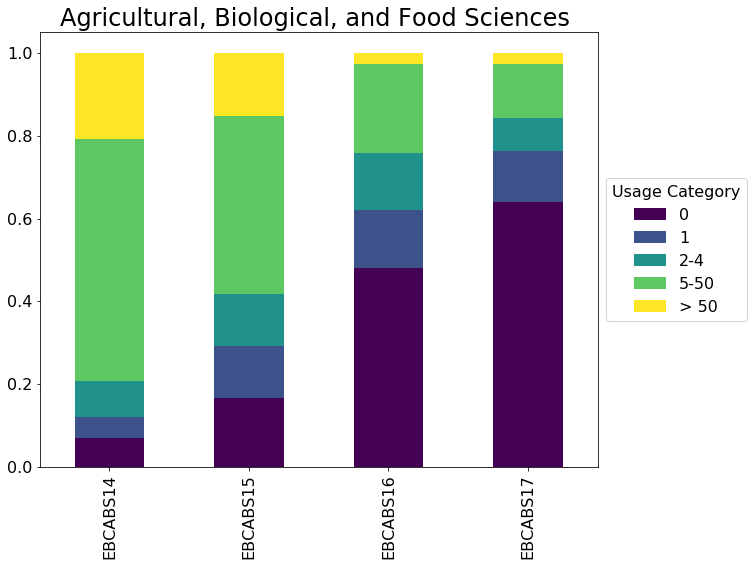

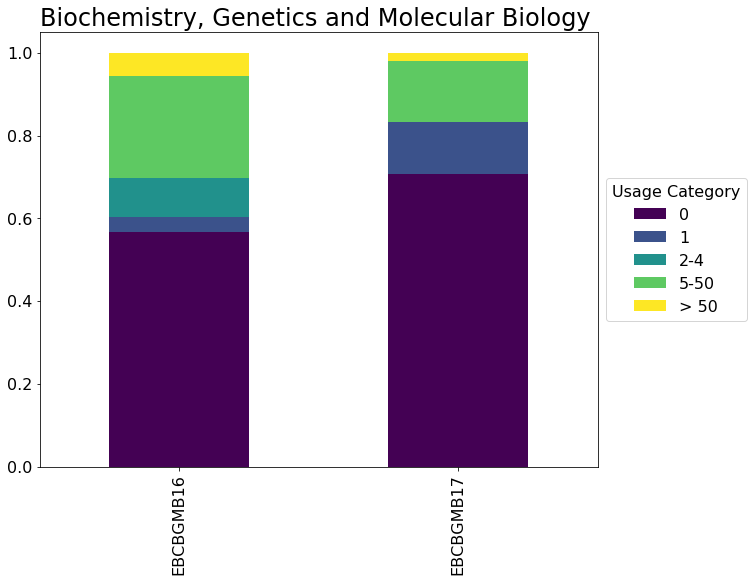

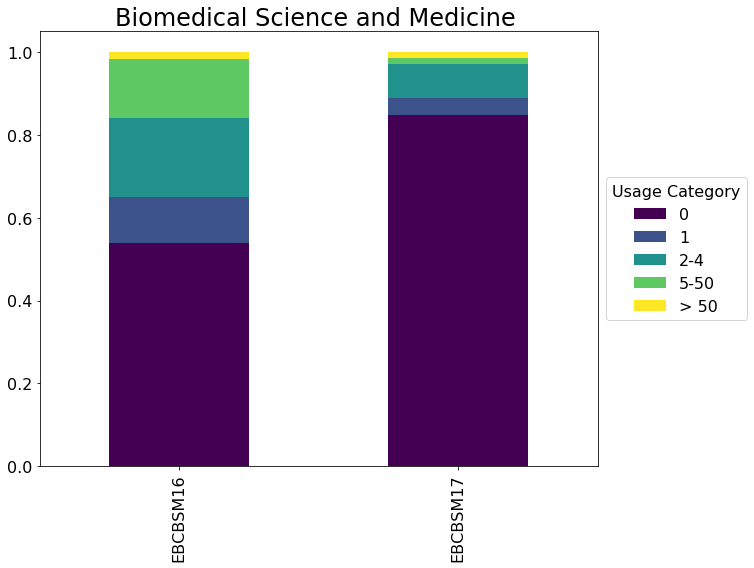

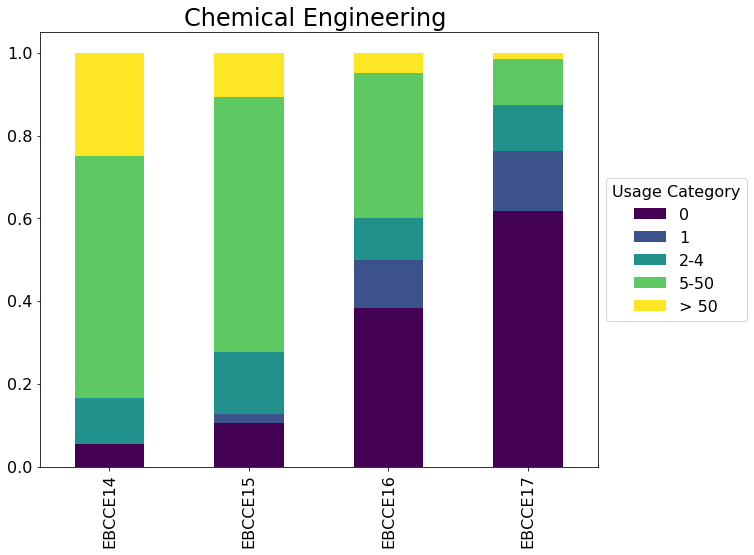

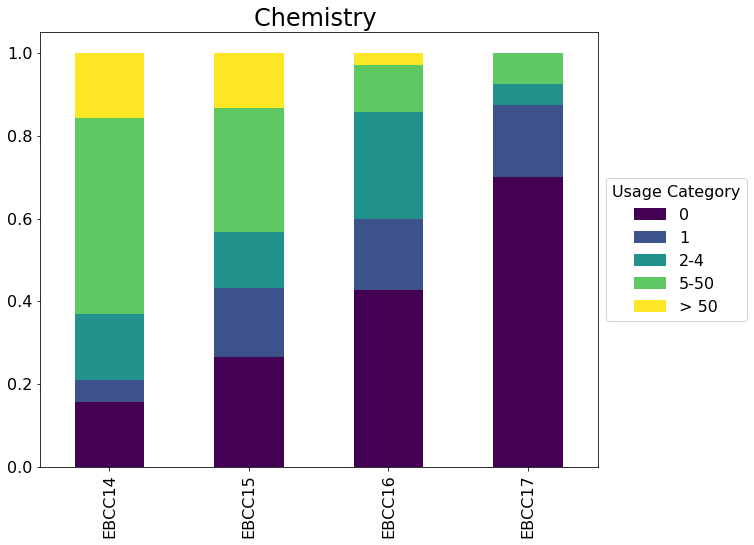

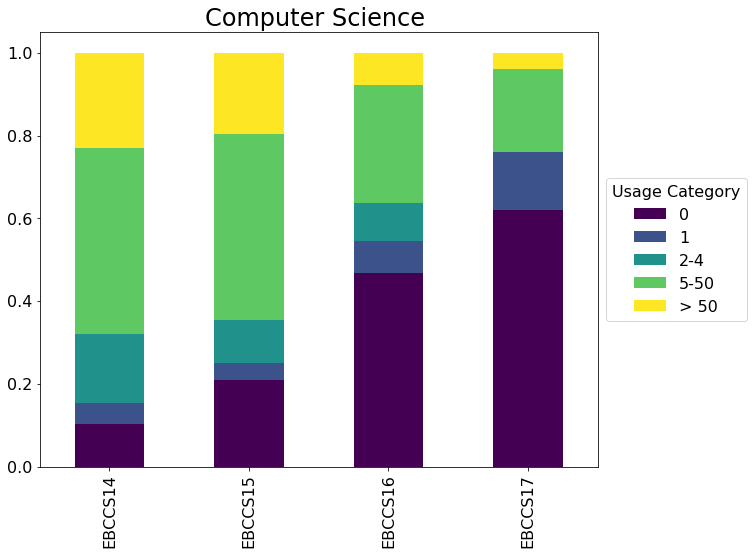

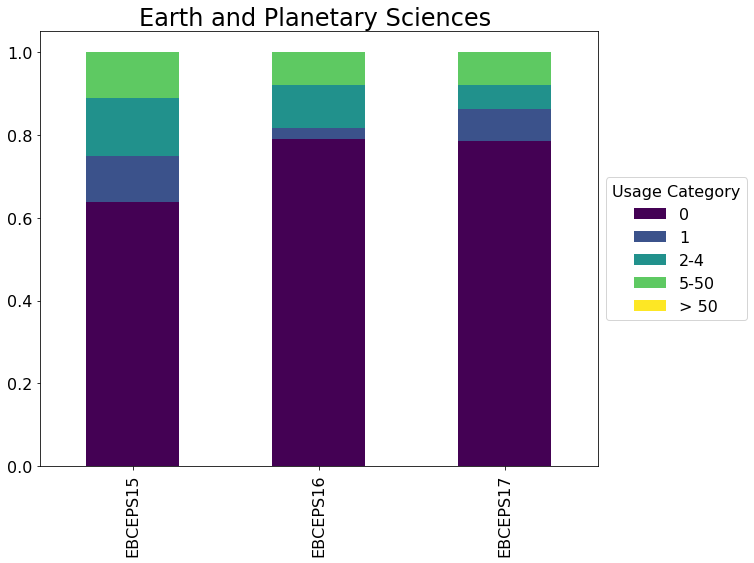

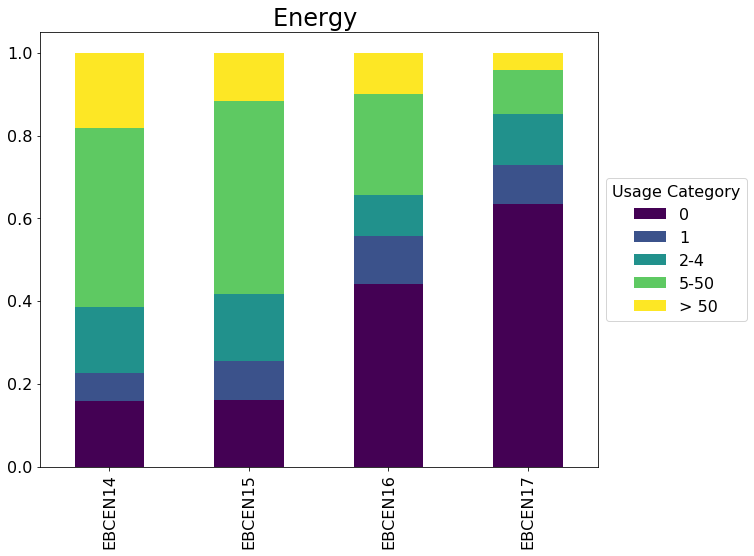

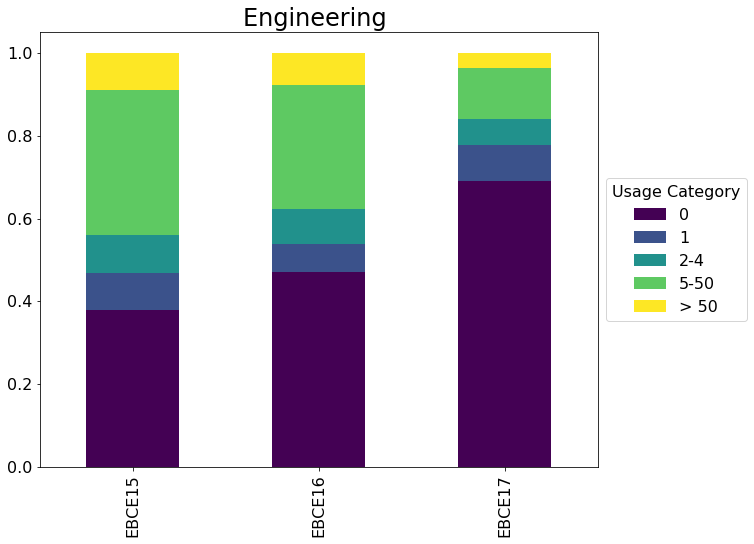

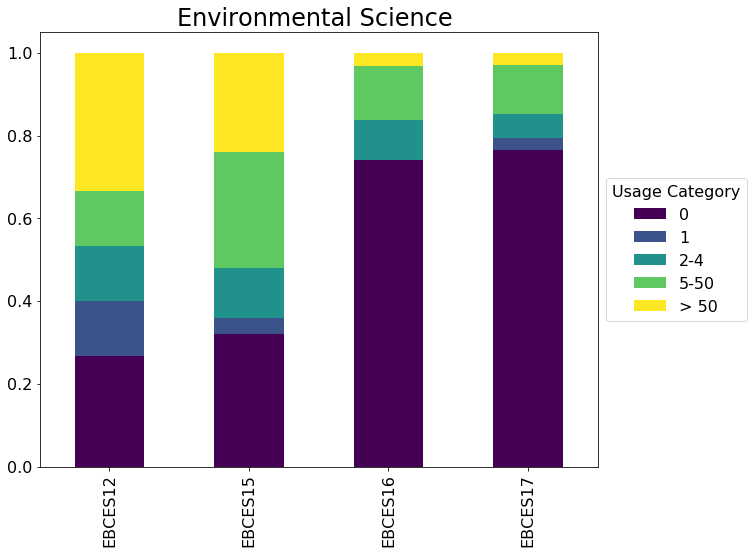

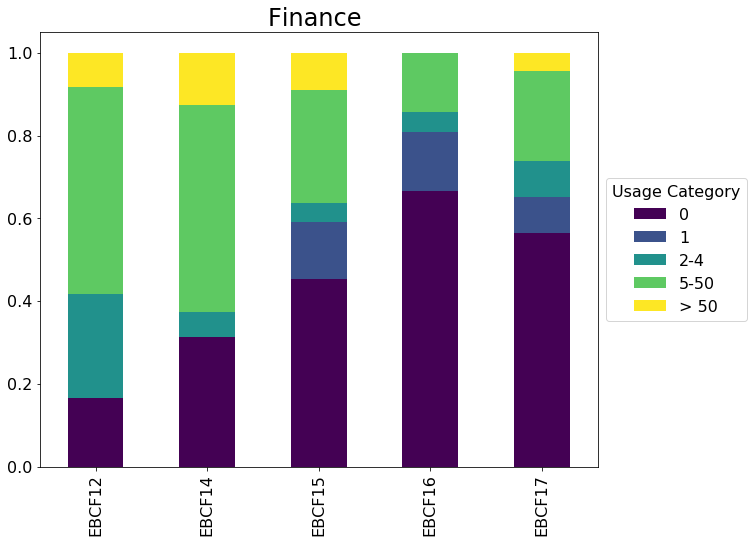

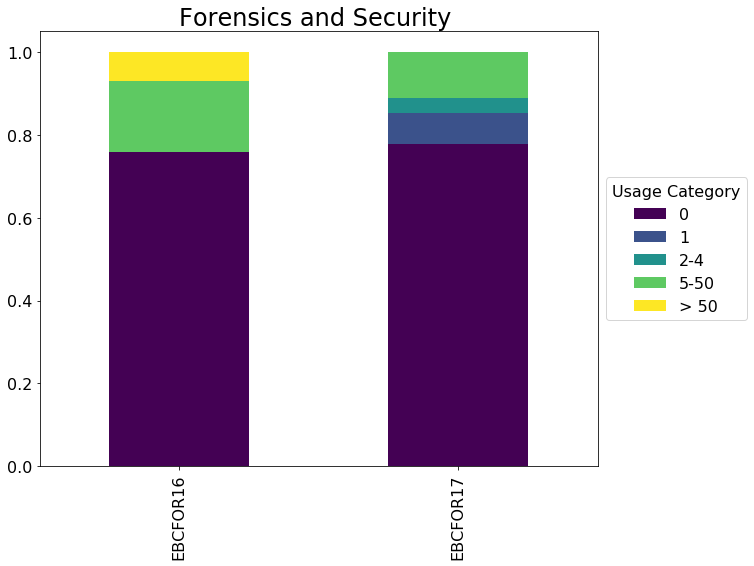

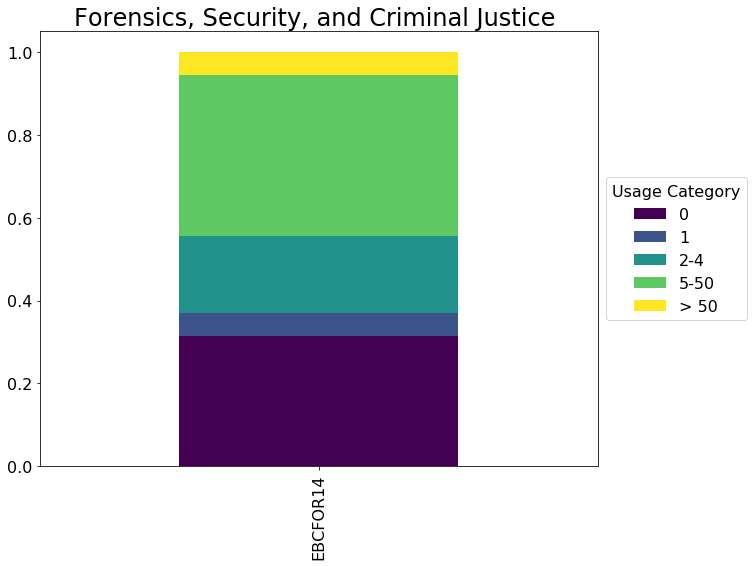

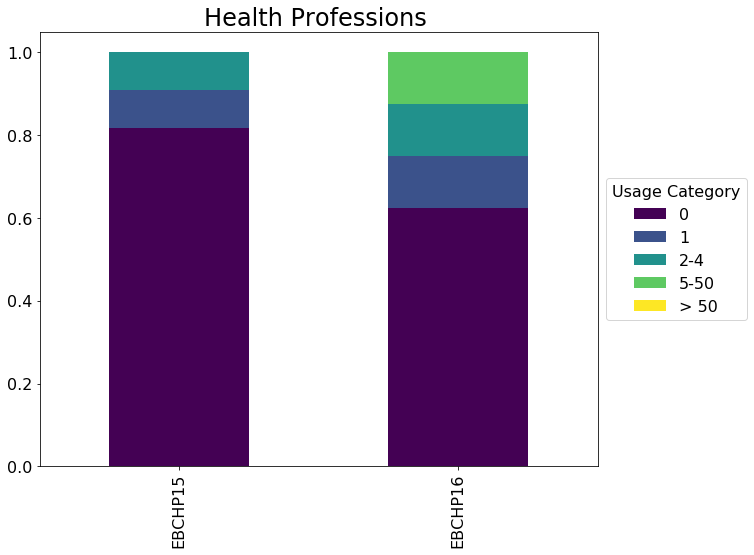

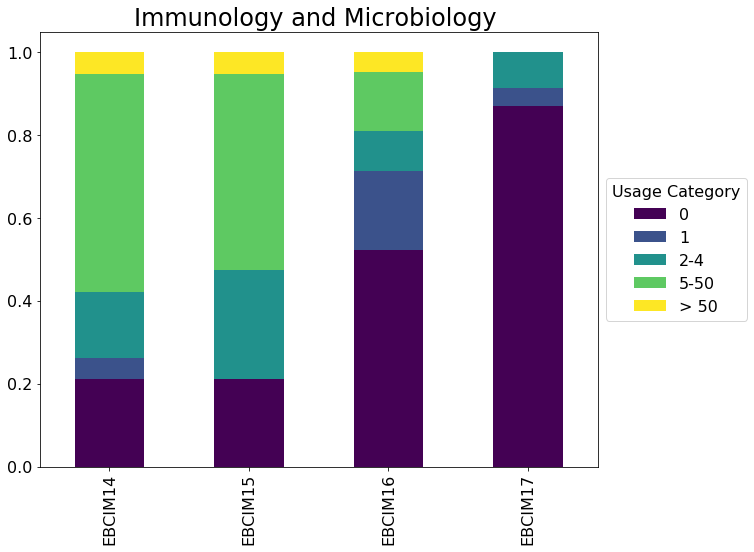

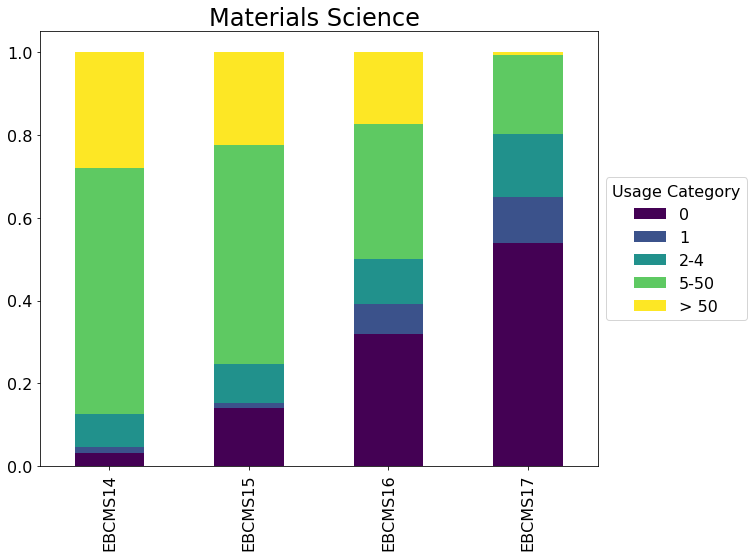

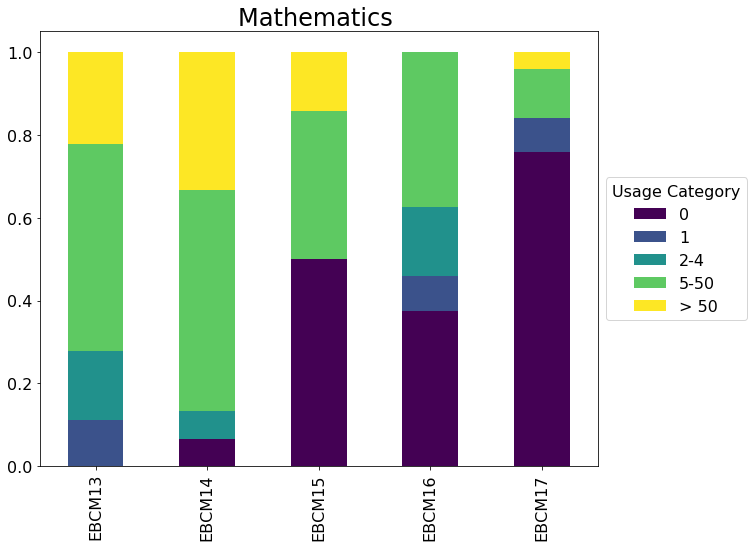

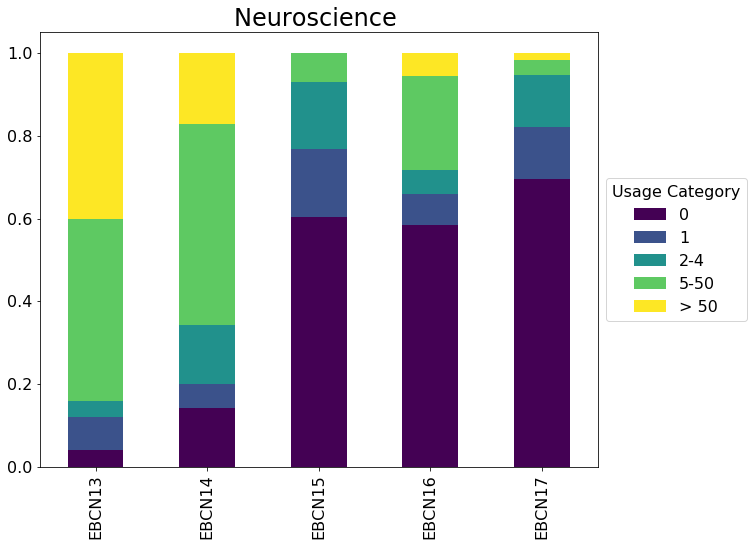

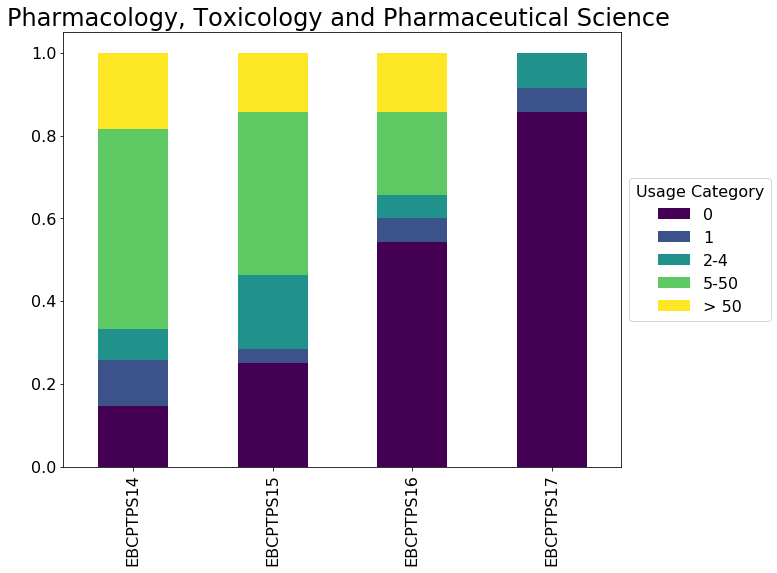

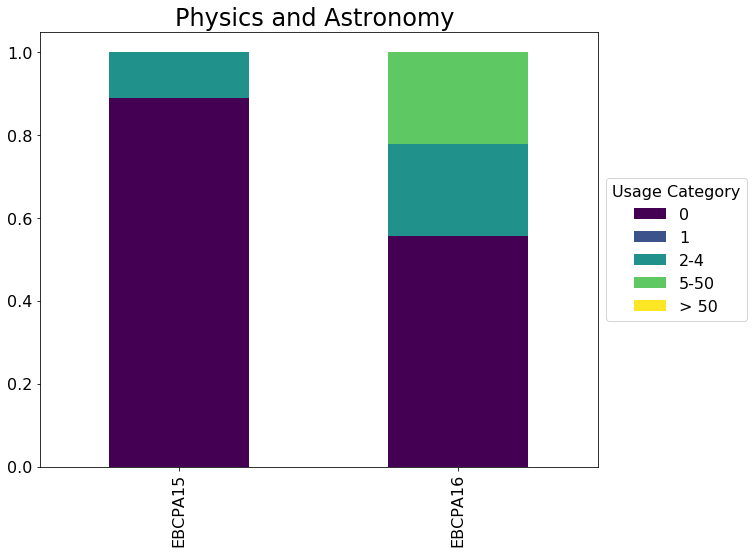

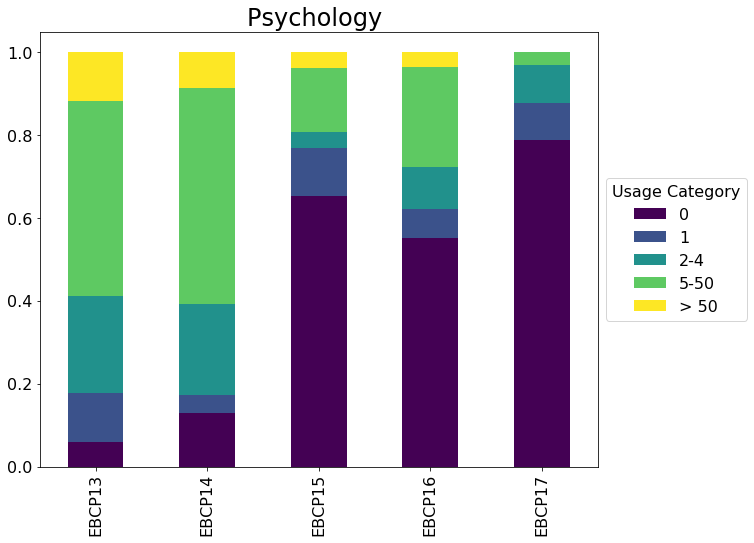

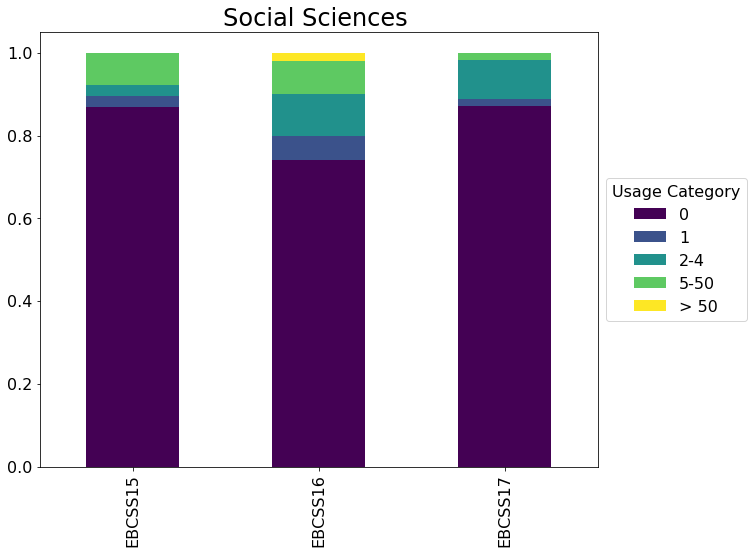

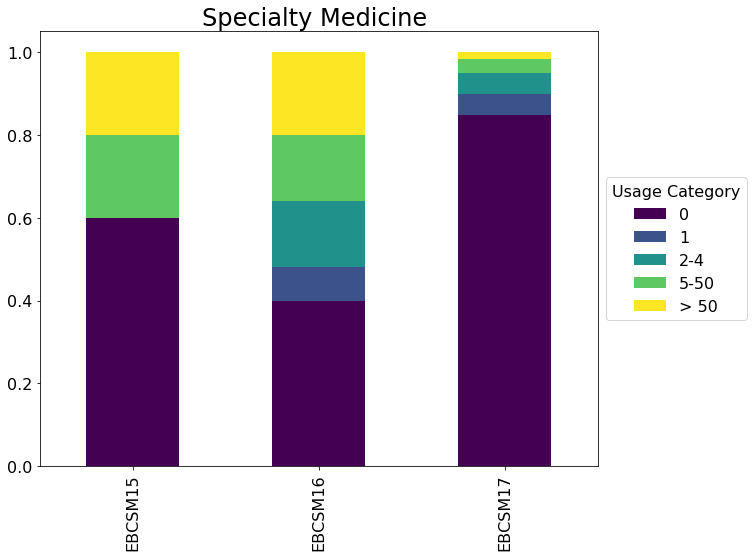

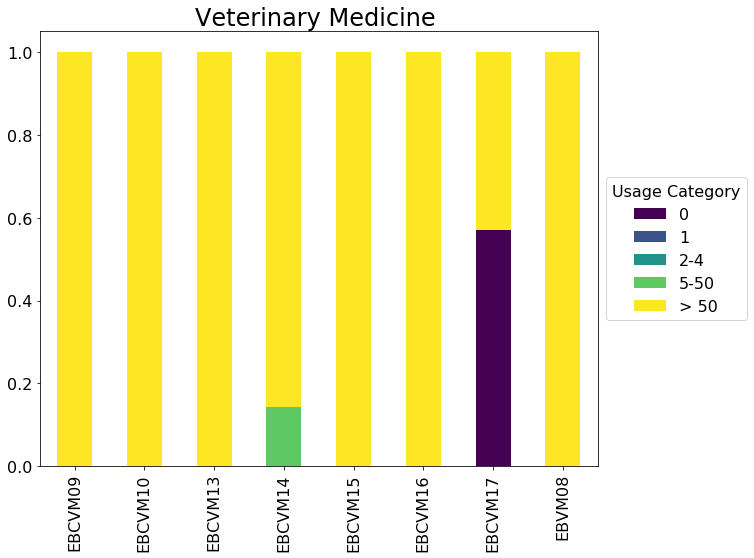

In [27]:
# hide a "max open warning" since we'll be looping over quite a few packages
plt.rcParams.update({'figure.max_open_warning': 0})

# Loop over each Package and create a stacked bar chart
for title, pkg in charts.groupby(['Package']):
    ax = pkg.plot(kind='bar', title=title, stacked=True, rot=90, colormap='viridis', figsize=(10,8), fontsize=16)
    ax.set_title(title, fontsize=24)
    ax.set_xlabel('')
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
    leg.set_title('Usage Category',prop={'size':16})